In [1]:
from __future__ import annotations
try:
    from scripts_for_plotting import *
except ModuleNotFoundError:
    import sys
    sys.path.append('../')
    from scripts_for_plotting import *

import scienceplots
plt.style.use('science')
plt.style.use('notebook')
import ipyparallel as ipp

In [2]:
observed_path = "/media/advait/DATA/research/rcb-project/TSFitPy/input_files/observed_spectra"
star = "C38"
observed_file = f"{observed_path}/{star}.txt"
observed_data = np.loadtxt(observed_file, unpack=True)
obs_wave, obs_flux, obs_err = observed_data[0], observed_data[1], observed_data[2]

In [3]:
lists = {}
basepath = "../input_files/linelists/individual/"
lists['CN'] = basepath + "CN_new"
lists['12C16O'] = basepath + "12C16O"
lists['12C18O'] = basepath + "12C18O"
lists['C2'] = basepath + "C2"
lists['atoms'] = basepath + "atoms_6000K"

In [4]:
lines = pd.read_csv("/media/advait/DATA/research/rcb-project/code/lineranges/atomic.csv")
lines['wav'] = lines['wav']*1e-4

In [5]:
wavecorr = obs_wave*1e-4
fluxcorr = obs_flux

/tmp/ipykernel_1554953/2712347335.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k.-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(wavecorr, fluxcorr_filtered.real, "k.-", label='Filtered Signal', color='orange')


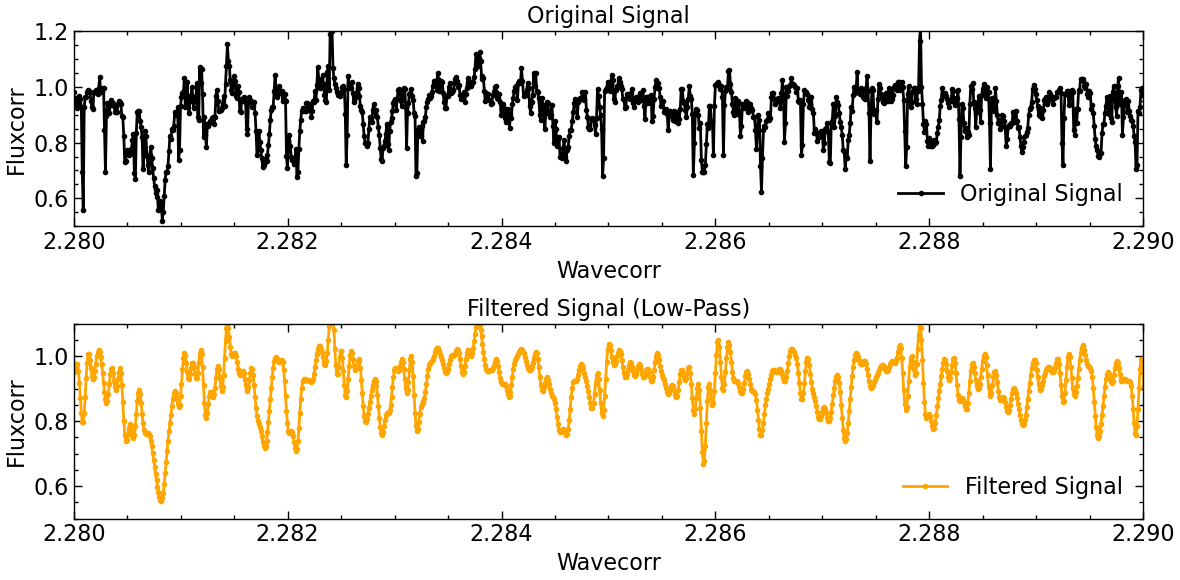

In [6]:


# Sample data (replace with actual data)
# wavecorr = np.linspace(0, 10, 1000)
# fluxcorr = np.sin(2 * np.pi * wavecorr) + 0.5 * np.sin(2 * np.pi * 5 * wavecorr)

# Compute the Fourier transform of fluxcorr
fluxcorr_fft = np.fft.fft(fluxcorr)
frequencies = np.fft.fftfreq(len(fluxcorr), d=(wavecorr[1] - wavecorr[0]))

# Define the cutoff frequency for the low-pass filter
cutoff_frequency =13000.0  # Adjust this value as needed
lmin = 22800e-4
lmax = 22900e-4

# Apply the low-pass filter
fluxcorr_fft_filtered = fluxcorr_fft.copy()
fluxcorr_fft_filtered[np.abs(frequencies) > cutoff_frequency] = 0

# Compute the inverse Fourier transform to get the filtered signal
fluxcorr_filtered = np.fft.ifft(fluxcorr_fft_filtered)

# Plot the original and filtered signals
plt.figure(figsize=(12, 6))

# Plot the original signal
plt.subplot(2, 1, 1)
plt.plot(wavecorr, fluxcorr, "k.-", label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Wavecorr')
plt.ylabel('Fluxcorr')
plt.legend()
plt.xlim(lmin, lmax)
plt.ylim(0.5,1.2)

# Plot the filtered signal
plt.subplot(2, 1, 2)
plt.plot(wavecorr, fluxcorr_filtered.real, "k.-", label='Filtered Signal', color='orange')
plt.title('Filtered Signal (Low-Pass)')
plt.xlabel('Wavecorr')
plt.ylabel('Fluxcorr')
plt.legend()
plt.ylim(0.5,1.1)

plt.xlim(lmin, lmax)

plt.tight_layout()
plt.show()
fluxcorr = fluxcorr_filtered.real

In [7]:
# apply same correction to errcorr
errcorr = obs_err
errcorr_fft = np.fft.fft(errcorr)
errcorr_fft_filtered = errcorr_fft.copy()
errcorr_fft_filtered[np.abs(frequencies) > cutoff_frequency] = 0
errcorr_filtered = np.fft.ifft(errcorr_fft_filtered)
errcorr = errcorr_filtered.real
errcorr = np.abs(errcorr)

In [8]:
# obs_wave += 0.3
# save the corrected observed spectrum
observed_file = f"{observed_path}/{star}_clean.txt"
np.savetxt(observed_file, np.array([obs_wave, fluxcorr, errcorr]).T , fmt = '%.4f %.4f %.4f', delimiter = ' ')


In [33]:
turbospectrum_paths = {"turbospec_path": "../turbospectrum/exec-ifx/",  # change to /exec-gf/ if gnu compiler
                       "interpol_path": "../scripts/model_interpolators/",
                       "model_atom_path": "../input_files/nlte_data/model_atoms/",
                       "departure_file_path": "../input_files/nlte_data/",
                    #    "model_atmosphere_grid_path": "../input_files/test_model_atmospheres/",
                        "model_atmosphere_grid_path": "../input_files/hdc_model_atmospheres/",
                       "line_list_path": "../input_files/linelists/linelist_6000K/"}

teff = 5750
logg = 1.0
met = 0.0
vmic = 6.5
lmin = np.min(obs_wave).round(2)
lmax = 2.5e4
# lmax = 22700
ldelta = 0.1
atmosphere_type = "1D"   # "1D" or "3D"
nlte_flag = False
elements_in_nlte = ["Fe", "Mg"]  # can choose several elements, used ONLY if nlte_flag = True

nguess =  9.5
oguess = 8.895
rat = 0.73
# element_abundances ={"H" : 7.5-12, "He" : 11.5-10.93, "C" : 9.52-8.56, "N" : nguess-7.98, "O" : oguess-8.77, "Fe" : 0.0, "Mg" : -1, "S" : -1, "Si": -1, "Na":-1} 
# nguess = 
element_abundances ={"H" : 7.5-12, "He" : 11.5-10.93, "C" : 9.713-8.56, "N" : nguess-7.98, "O" : oguess-8.77, "Na" : 0.62, "Mg":0.58, "Fe":0.09, "Ca":0.04, "S":0.24, "Si":0.2}  # elemental abundances [X/Fe]; if not written solar scaled ones are used

vmac = 0
free_isotopes = {"8.016" : rat/(1+rat), "8.017": 0.0, "8.018": 1/(1+rat)}
include_molecules = True  


In [34]:
element_abundances

{'H': -4.5,
 'He': 0.5700000000000003,
 'C': 1.1529999999999987,
 'N': 1.5199999999999996,
 'O': 0.125,
 'Na': 0.62,
 'Mg': 0.58,
 'Fe': 0.09,
 'Ca': 0.04,
 'S': 0.24,
 'Si': 0.2}

In [10]:
lmin = 22670
lmax = 22820
wavelength, flux = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)


Trimming
Trimming done
Running TS
TS completed


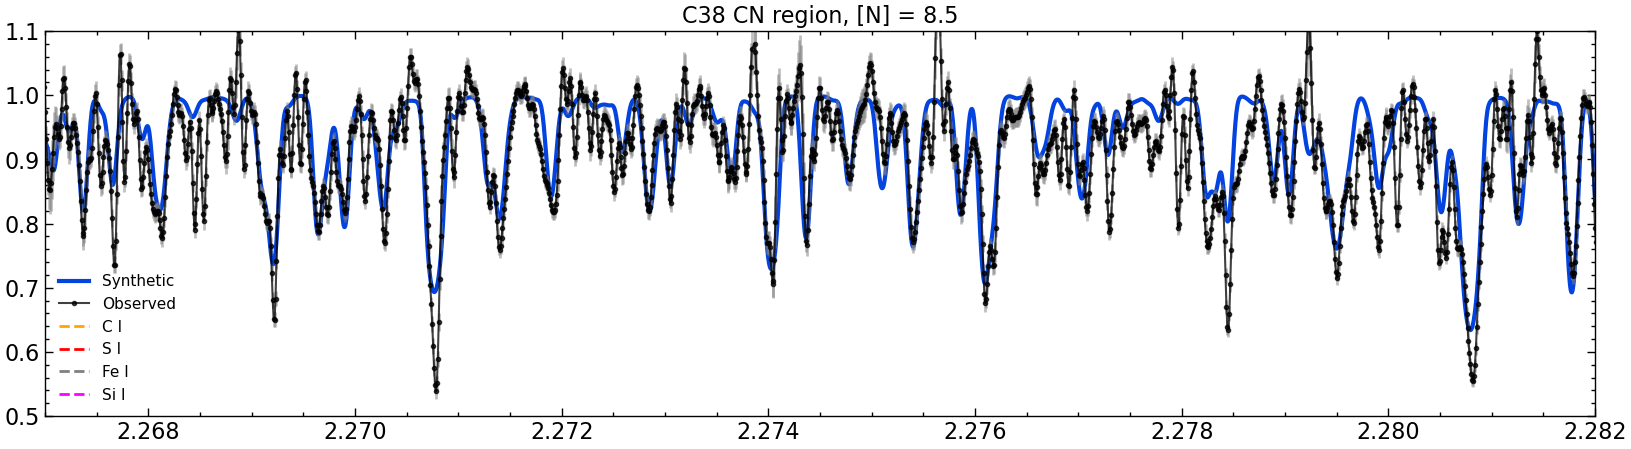

In [100]:
plt.figure(figsize=(20, 5))
plt.plot(wavelength*1e-4, flux, 'xkcd:blue', lw = 3,  label="Synthetic")

plt.errorbar(wavecorr, fluxcorr, yerr=np.abs(errcorr), fmt="none", ecolor="gray", alpha=0.5)
plt.plot(wavecorr, fluxcorr, "k.-", alpha=0.75, lw =1.5 ,  label="Observed")
plt.xlim(lmin*1e-4, lmax*1e-4)
plt.ylim(0.5, 1.1)
plt.axvline(22684, ls="--", color="orange", label="C I")
plt.axvline(22707.5, ls="--", color="red", label="S I")
plt.axvline(22740.3, ls="--", color="gray", label="Fe I")
plt.axvline(22770.2, ls="--", color="gray")
plt.axvline(22751, ls="--", color="magenta", label="Si I")
plt.title(f"{star} CN region, [N] = {nguess}")
plt.legend(fontsize=11)

In [101]:
lmin = 23060
lmax = 23080
vmic = 5
wavelength, flux = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths['line_list_path'] = lists['CN'] 
wavelength, syntflux_CN = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths['line_list_path'] = lists['C2'] 
wavelength3, syntflux_C2 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)

Trimming
Trimming done
Running TS
TS completed
Trimming
LINELIST WARNING! File /media/advait/DATA/research/rcb-project/TSFitPy/lineranges/../input_files/linelists/individual/CN_new/12C14N_TriHy2.plez.bz2 is not a valid linelist file
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed


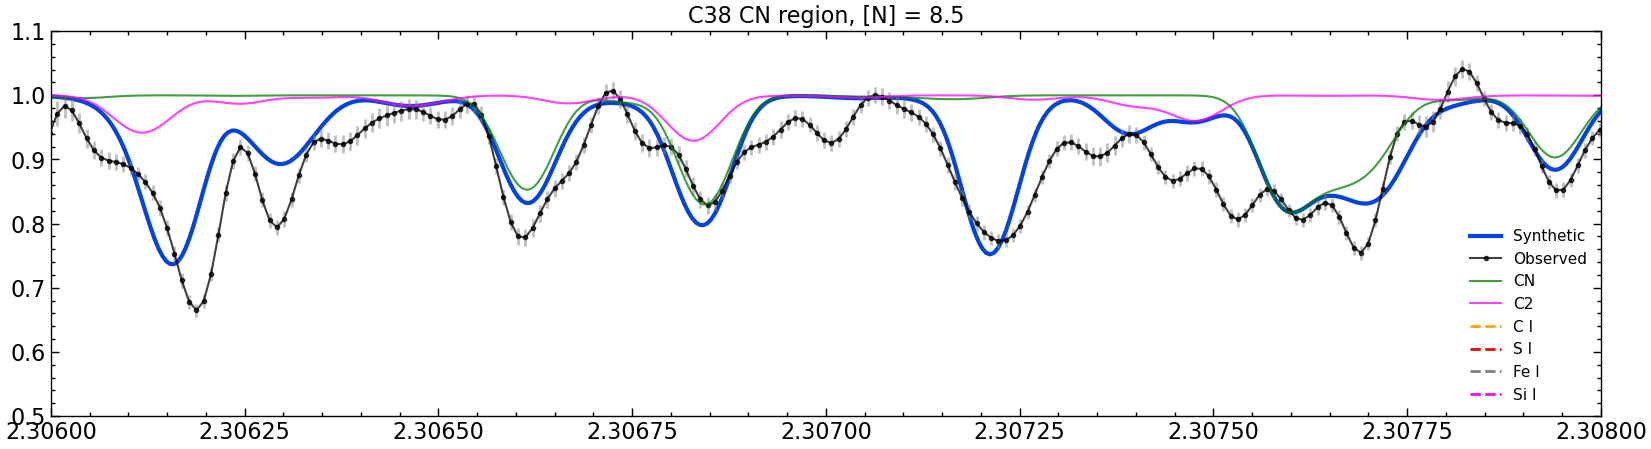

In [102]:
plt.figure(figsize=(20, 5))
plt.plot(wavelength*1e-4, flux, 'xkcd:blue', lw = 3,  label="Synthetic")

plt.errorbar(wavecorr, fluxcorr, yerr=np.abs(errcorr), fmt="none", ecolor="gray", alpha=0.5)
plt.plot(wavecorr, fluxcorr, "k.-", alpha=0.75, lw =1.5 ,  label="Observed")
plt.plot(wavelength*1e-4, syntflux_CN, "g", alpha=0.75, lw =1.5 ,  label="CN")
plt.plot(wavelength3*1e-4, syntflux_C2, "magenta", alpha=0.75, lw =1.5 ,  label="C2")
plt.xlim(lmin*1e-4, lmax*1e-4)
plt.ylim(0.5, 1.1)
plt.axvline(22684, ls="--", color="orange", label="C I")
plt.axvline(22707.5, ls="--", color="red", label="S I")
plt.axvline(22740.3, ls="--", color="gray", label="Fe I")
plt.axvline(22770.2, ls="--", color="gray")
plt.axvline(22751, ls="--", color="magenta", label="Si I")
plt.title(f"{star} CN region, [N] = {nguess}")
plt.legend(fontsize=11)

In [107]:
lmin = 22720
lmax = 22750
vmic = 5
turbospectrum_paths['line_list_path'] = "../input_files/linelists/linelist_6000K/"
wavelength, flux = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths['line_list_path'] = lists['CN'] 
wavelength, syntflux_CN = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths['line_list_path'] = lists['C2'] 
wavelength3, syntflux_C2 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)

Trimming
Trimming done
Running TS
TS completed
Trimming
LINELIST WARNING! File /media/advait/DATA/research/rcb-project/TSFitPy/lineranges/../input_files/linelists/individual/CN_new/12C14N_TriHy2.plez.bz2 is not a valid linelist file
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed


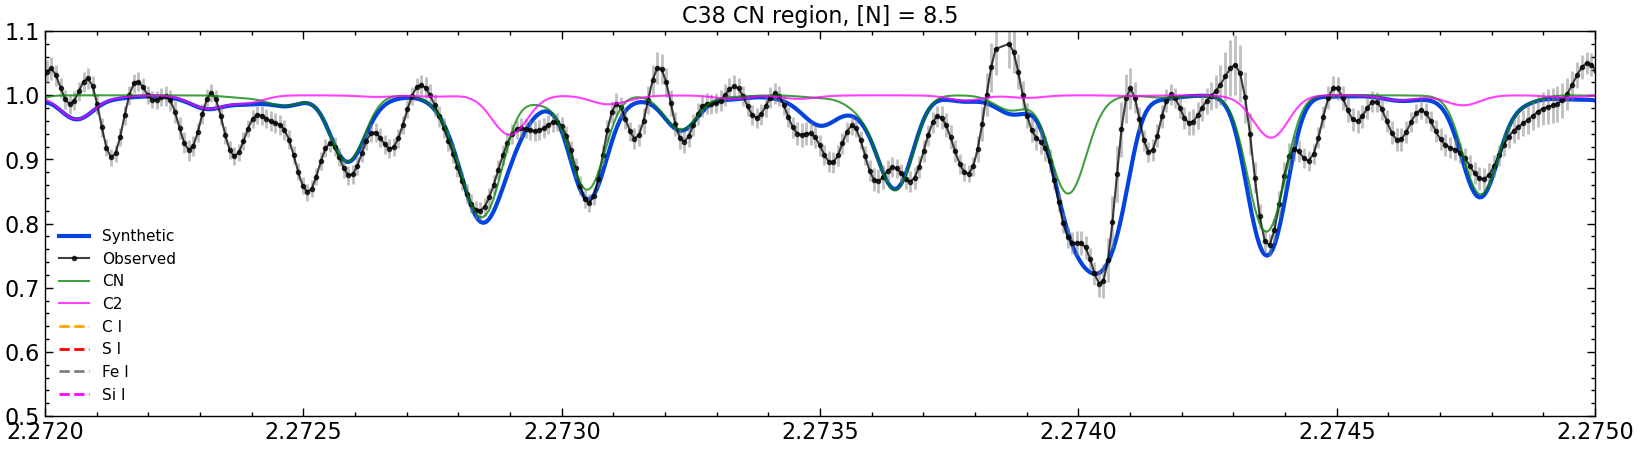

In [108]:
plt.figure(figsize=(20, 5))
plt.plot(wavelength*1e-4, flux, 'xkcd:blue', lw = 3,  label="Synthetic")

plt.errorbar(wavecorr, fluxcorr, yerr=np.abs(errcorr), fmt="none", ecolor="gray", alpha=0.5)
plt.plot(wavecorr, fluxcorr, "k.-", alpha=0.75, lw =1.5 ,  label="Observed")
plt.plot(wavelength*1e-4, syntflux_CN, "g", alpha=0.75, lw =1.5 ,  label="CN")
plt.plot(wavelength3*1e-4, syntflux_C2, "magenta", alpha=0.75, lw =1.5 ,  label="C2")
plt.xlim(lmin*1e-4, lmax*1e-4)
plt.ylim(0.5, 1.1)
plt.axvline(22684, ls="--", color="orange", label="C I")
plt.axvline(22707.5, ls="--", color="red", label="S I")
plt.axvline(22740.3, ls="--", color="gray", label="Fe I")
plt.axvline(22770.2, ls="--", color="gray")
plt.axvline(22751, ls="--", color="magenta", label="Si I")
plt.title(f"{star} CN region, [N] = {nguess}")
plt.legend(fontsize=11)

In [47]:
for element in element_abundances.keys():
    print(f"{element} : {element_abundances[element] + solar_abundances[element]}")

H : 7.5
He : 11.5
C : 9.5
N : 8.3
O : 8.8
Na : 6.9


In [56]:
turbospectrum_paths = {"turbospec_path": "../turbospectrum/exec-ifx/",  # change to /exec-gf/ if gnu compiler
                       "interpol_path": "../scripts/model_interpolators/",
                       "model_atom_path": "../input_files/nlte_data/model_atoms/",
                       "departure_file_path": "../input_files/nlte_data/",
                    #    "model_atmosphere_grid_path": "../input_files/test_model_atmospheres/",
                        "model_atmosphere_grid_path": "../input_files/hdc_model_atmospheres/",
                       "line_list_path": "../input_files/linelists/linelist_6000K/"}

teff = 5750
logg = 1.0
met = 0.0
vmic = 6.5
lmin = np.min(obs_wave).round(2)
lmax = 2.5e4
# lmax = 22700
ldelta = 0.1
atmosphere_type = "1D"   # "1D" or "3D"
nlte_flag = False
elements_in_nlte = ["Fe", "Mg"]  # can choose several elements, used ONLY if nlte_flag = True

nguess =  9.471
oguess = 9.046
rat = 0.73
# element_abundances ={"H" : 7.5-12, "He" : 11.5-10.93, "C" : 9.52-8.56, "N" : nguess-7.98, "O" : oguess-8.77, "Fe" : 0.0, "Mg" : -1, "S" : -1, "Si": -1, "Na":-1} 
# nguess = 
element_abundances ={"H" : 7.5-12, "He" : 11.5-10.93, "C" : 10.151-8.56, "N" : nguess-7.98, "O" : oguess-8.77, "Na" : 0.62, "Mg":0.74, "Fe":0.24, "Ca":0.04, "S":0.16, "Si":0.2}  # elemental abundances [X/Fe]; if not written solar scaled ones are used

vmac = 0
free_isotopes = {"8.016" : rat/(1+rat), "8.017": 0.0, "8.018": 1/(1+rat)}
include_molecules = True  


In [57]:
element_abundances

{'H': -4.5,
 'He': 0.5700000000000003,
 'C': 1.5909999999999993,
 'N': 1.4909999999999997,
 'O': 0.2759999999999998,
 'Na': 0.62,
 'Mg': 0.74,
 'Fe': 0.24,
 'Ca': 0.04,
 'S': 0.16,
 'Si': 0.2}

In [58]:
for element in element_abundances.keys():
    print(f"{element} : {element_abundances[element] + solar_abundances[element]}")

H : 7.5
He : 11.5
C : 10.151
N : 9.471
O : 9.046
Na : 6.91
Mg : 8.29
Fe : 7.74
Ca : 6.41
S : 7.32
Si : 7.79


In [59]:
turbospectrum_paths['line_list_path'] = lists['CN'] 
wavelength, syntflux_CN = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)

turbospectrum_paths['line_list_path'] = lists['12C16O'] 
wavelength1, syntflux_CO16 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)

turbospectrum_paths['line_list_path'] = lists['12C18O'] 
wavelength2, syntflux_CO18 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)

turbospectrum_paths['line_list_path'] = lists['C2'] 
wavelength3, syntflux_C2 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)

turbospectrum_paths['line_list_path'] = lists['atoms'] 
wavelength4, syntflux_atoms = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)

Trimming
LINELIST WARNING! File /media/advait/DATA/research/rcb-project/TSFitPy/lineranges/../input_files/linelists/individual/CN_new/12C14N_TriHy2.plez.bz2 is not a valid linelist file
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed


In [60]:
turbospectrum_paths['line_list_path'] = "../input_files/linelists/linelist_6000K/"
wavelength, syntflux_all = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)

# turbospectrum_paths['line_list_path'] = lists['C2'] 
# element_abundances ={"H" : 7.5-12, "He" : 11.5-10.93, "C" : 9.5-8.56 + 0.7, "N" : nguess-7.98, "O" : 8.8-8.77, "Na" : 6.9-6.29}  # elemental abundances [X/Fe]; if not written solar scaled ones are used
# wavelength3, syntflux_C2_high = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=0, rotation=0, do_matplotlib_plot=False)

Trimming
Trimming done
Running TS
TS completed


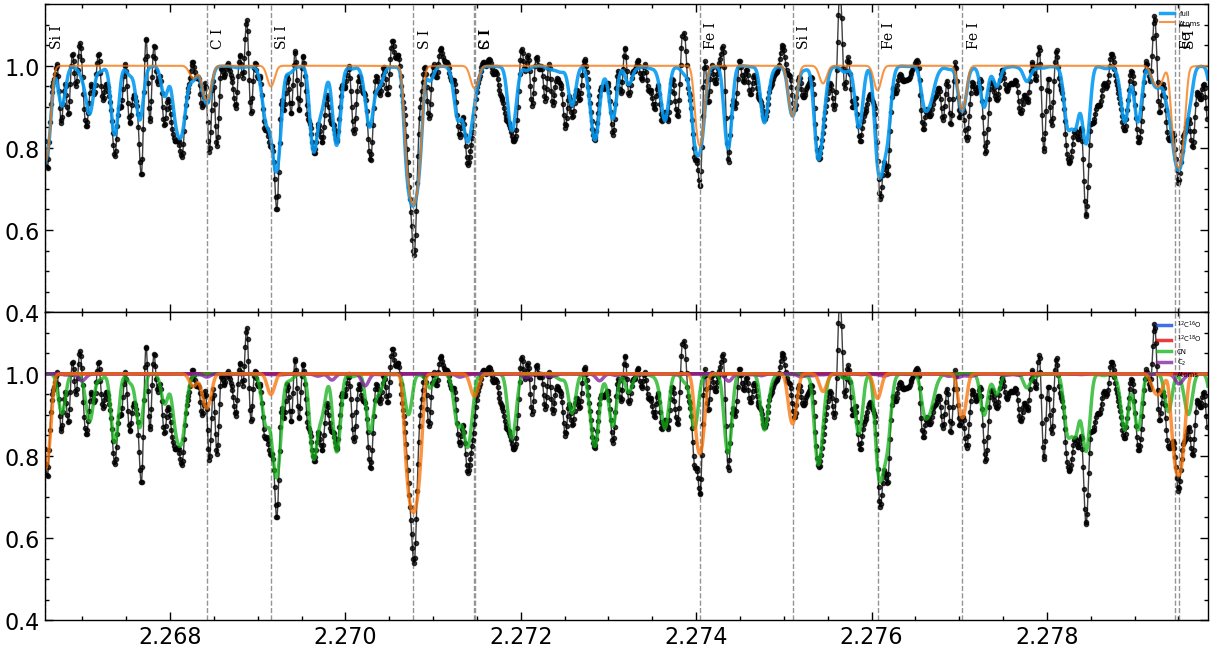

In [40]:
n = 20

mask = wavecorr < 2.5
fluxcorr = fluxcorr[mask]
wavecorr = wavecorr[mask]
wavmin = np.min(wavecorr)
wavspan = np.max(wavecorr)-np.min(wavecorr)

# for i in range(n):
    # i = 2
fig, (axs, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plt.subplots_adjust(wspace=0, hspace=0)

# wav_range = [2.29, 2.30]
i = 1
buffer = 0.0005
wav_range = (wavmin + i/n*wavspan - buffer, wavmin + (i+1)/n*wavspan + buffer)

mask = (wavecorr > wav_range[0]) & (wavecorr < wav_range[1])
axs.set_xlim(wav_range)
ax2.set_xlim(wav_range)
axs.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
f = 0.1
fluxcorr2 = (fluxcorr - f)/(1-f)
# ax2.plot(wavecorr[mask], fluxcorr2[mask], "r.-", lw = 1, alpha=0.75)
# axs.plot(wavecorr[mask], fluxcorr2[mask], "r.-", lw = 1, alpha=0.75)

axs.plot(wavelength*1e-4, syntflux_all, lw = 2.5, c = 'xkcd:azure', alpha = 0.9, label = r"full")
axs.plot(wavelength*1e-4, syntflux_atoms, lw = 1.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
axs.set_ylim(0.4, 1.15)
ax2.set_ylim(0.4, 1.15)
axs.legend(fontsize=5, loc = 'upper right')
axs.set_xticklabels([])
prev_wav = 0
prev_name = ''
for idx, row in lines.iterrows():
    near = False
    same = False

    if row['wav'] > wav_range[0] and row['wav'] < wav_range[1]:
        linewav = row['wav']
        # find nearest syntwave index to linewav
        idx = np.argmin(np.abs(wavelength*1e-4 - linewav))
        thresh = 0.95
        wav_gap_thresh = 1e-4
        if syntflux_atoms[idx] < thresh:
            near = abs(prev_wav - linewav) < wav_gap_thresh
            # print(abs(prev_wav - linewav))
            # print(near)
            same = prev_name == row['name']
            if (not near) :
                axs.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                axs.text(row['wav']+5e-5, 1.05, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                ax2.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                # ax2.text(row['wav']+5e-5, 1.15, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                prev_wav, prev_name = row['wav'], row['name']
            else:
                print("too near")
ax2.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
ax2.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
ax2.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
ax2.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
# offset = -5e-4
ax2.plot(wavelength*1e-4, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
# 2xs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
ax2.plot(wavelength*1e-4, syntflux_atoms, lw = 2.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
ax2.legend(fontsize=5, loc = 'upper right')


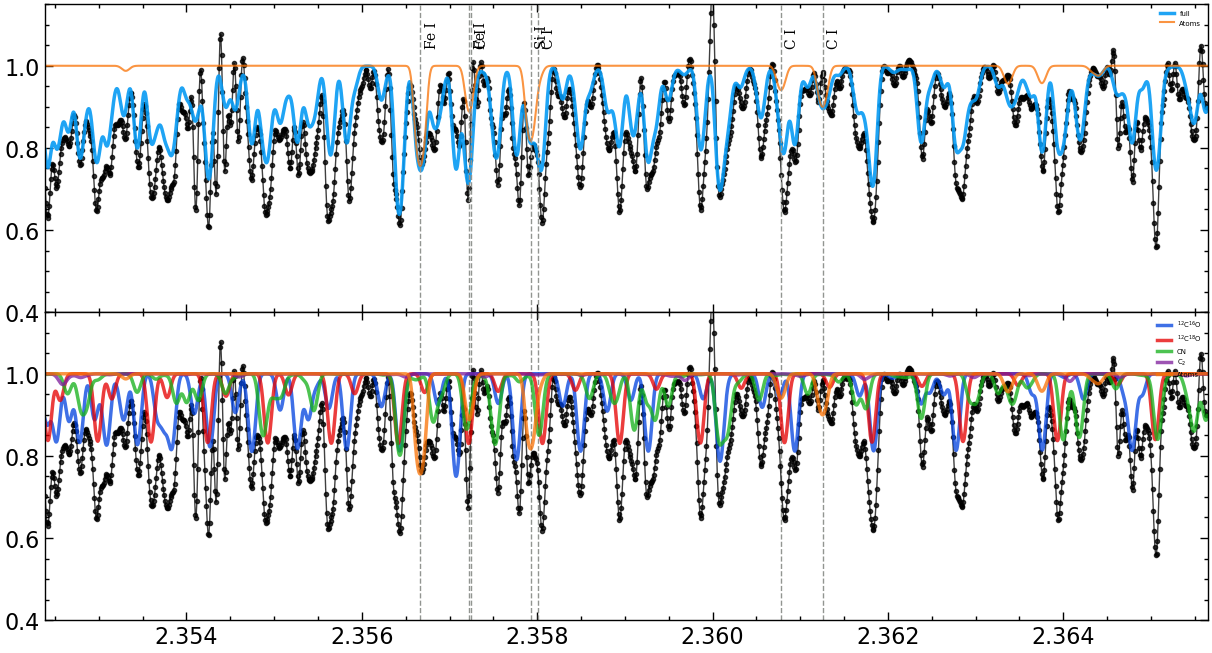

In [41]:
n = 20

mask = wavecorr < 2.5
fluxcorr = fluxcorr[mask]
wavecorr = wavecorr[mask]
wavmin = np.min(wavecorr)
wavspan = np.max(wavecorr)-np.min(wavecorr)

# for i in range(n):
    # i = 2
fig, (axs, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plt.subplots_adjust(wspace=0, hspace=0)

# wav_range = [2.29, 2.30]
i = 8
buffer = 0.0005
wav_range = (wavmin + i/n*wavspan - buffer, wavmin + (i+1)/n*wavspan + buffer)

mask = (wavecorr > wav_range[0]) & (wavecorr < wav_range[1])
axs.set_xlim(wav_range)
ax2.set_xlim(wav_range)
axs.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
f = 0.1
fluxcorr2 = (fluxcorr - f)/(1-f)
# ax2.plot(wavecorr[mask], fluxcorr2[mask], "r.-", lw = 1, alpha=0.75)
# axs.plot(wavecorr[mask], fluxcorr2[mask], "r.-", lw = 1, alpha=0.75)

axs.plot(wavelength*1e-4, syntflux_all, lw = 2.5, c = 'xkcd:azure', alpha = 0.9, label = r"full")
axs.plot(wavelength*1e-4, syntflux_atoms, lw = 1.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
axs.set_ylim(0.4, 1.15)
ax2.set_ylim(0.4, 1.15)
axs.legend(fontsize=5, loc = 'upper right')
axs.set_xticklabels([])
prev_wav = 0
prev_name = ''
for idx, row in lines.iterrows():
    near = False
    same = False

    if row['wav'] > wav_range[0] and row['wav'] < wav_range[1]:
        linewav = row['wav']
        # find nearest syntwave index to linewav
        idx = np.argmin(np.abs(wavelength*1e-4 - linewav))
        thresh = 0.95
        wav_gap_thresh = 1e-4
        if syntflux_atoms[idx] < thresh:
            near = abs(prev_wav - linewav) < wav_gap_thresh
            # print(abs(prev_wav - linewav))
            # print(near)
            same = prev_name == row['name']
            if (not near) :
                axs.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                axs.text(row['wav']+5e-5, 1.05, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                ax2.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                # ax2.text(row['wav']+5e-5, 1.15, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                prev_wav, prev_name = row['wav'], row['name']
            else:
                print("too near")
ax2.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
ax2.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
ax2.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
ax2.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
# offset = -5e-4
ax2.plot(wavelength*1e-4, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
# 2xs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
ax2.plot(wavelength*1e-4, syntflux_atoms, lw = 2.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
ax2.legend(fontsize=5, loc = 'upper right')


In [61]:
# create a directory for the star name in this folder if it doesnt exist
if not os.path.exists(f"./{star}"):
    os.makedirs(f"./{star}")

In [62]:
n = 20

mask = wavecorr < 2.5
fluxcorr = fluxcorr[mask]
wavecorr = wavecorr[mask]
wavmin = np.min(wavecorr)
wavspan = np.max(wavecorr)-np.min(wavecorr)

for i in range(n):
    # i = 2
    fig, (axs, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    plt.subplots_adjust(wspace=0, hspace=0)
    buffer = 0.0005
    wav_range = (wavmin + i/n*wavspan - buffer, wavmin + (i+1)/n*wavspan + buffer)
    mask = (wavecorr > wav_range[0]) & (wavecorr < wav_range[1])
    axs.set_xlim(wav_range)
    ax2.set_xlim(wav_range)
    axs.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
    # axs.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
    # axs.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
    # axs.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
    axs.plot(wavelength*1e-4, syntflux_all, lw = 2.5, c = 'xkcd:azure', alpha = 0.9, label = r"full")
    # axs.plot(wavelength*1e-4, syntflux_C2_high, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$+ 0.7")
    # axs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
    axs.plot(wavelength*1e-4, syntflux_atoms, lw = 1.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
    axs.set_ylim(0.4, 1.15)
    ax2.set_ylim(0.4, 1.15)
    axs.legend(fontsize=5, loc = 'upper right')
    axs.set_xticklabels([])
    # axs.grid(which='both', linestyle='--', alpha = 0.5)

    

    # find the lines in the range
    prev_wav = 0
    prev_name = ''
    for idx, row in lines.iterrows():
        near = False
        same = False

        if row['wav'] > wav_range[0] and row['wav'] < wav_range[1]:
            linewav = row['wav']
            # find nearest syntwave index to linewav
            idx = np.argmin(np.abs(wavelength*1e-4 - linewav))
            thresh = 0.95
            wav_gap_thresh = 1e-4
            if syntflux_atoms[idx] < thresh:
                near = abs(prev_wav - linewav) < wav_gap_thresh
                same = prev_name == row['name']
                if (not near) :
                    axs.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                    axs.text(row['wav']+5e-5, 1.05, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                    ax2.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                    # ax2.text(row['wav']+5e-5, 1.15, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                    prev_wav, prev_name = row['wav'], row['name']
                else:
                    print("too near")
    ax2.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
    ax2.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
    ax2.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
    ax2.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
    ax2.plot(wavelength*1e-4, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
    # 2xs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
    ax2.plot(wavelength*1e-4, syntflux_atoms, lw = 2.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
    ax2.legend(fontsize=5, loc = 'upper right')

    

    # save the plot
    plt.savefig(f'./{star}/atom_{i}.png', dpi=300)
    # break
    plt.close()
    # axs.close()
    # axs[i].axhline(1.0, color = 'black', lw = 0.5)


too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near


: 

In [123]:
# create a directory for the star name in this folder if it doesnt exist
if not os.path.exists(f"./{star}/masks"):
    os.makedirs(f"./{star}/masks")

In [158]:
# lmask_path = "/media/advait/DATA/research/rcb-project/TSFitPy/input_files/linemask_files/N/low-n-lmask.txt"
lmask_path = "/media/advait/DATA/research/rcb-project/TSFitPy/input_files/linemask_files/O/omask-vmic.txt"
lmask = np.loadtxt(lmask_path, unpack=True, comments=";")
mid, left, right = lmask[0], lmask[1], lmask[2]

In [159]:
n = 20

mask = wavecorr < 2.5
fluxcorr = fluxcorr[mask]
wavecorr = wavecorr[mask]
wavmin = np.min(wavecorr)
wavspan = np.max(wavecorr)-np.min(wavecorr)

for i in range(n):
    # i = 4
    fig, (axs, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    plt.subplots_adjust(wspace=0, hspace=0)
    buffer = 0.0005
    wav_range = (wavmin + i/n*wavspan - buffer, wavmin + (i+1)/n*wavspan + buffer)
    mask = (wavecorr > wav_range[0]) & (wavecorr < wav_range[1])
    axs.set_xlim(wav_range)
    ax2.set_xlim(wav_range)
    axs.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
    # axs.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
    # axs.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
    # axs.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
    axs.plot(wavelength*1e-4, syntflux_all, lw = 2.5, c = 'xkcd:azure', alpha = 0.9, label = r"full")
    # axs.plot(wavelength*1e-4, syntflux_C2_high, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$+ 0.7")
    # axs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
    axs.plot(wavelength*1e-4, syntflux_atoms, lw = 1.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
    axs.set_ylim(0.4, 1.15)
    ax2.set_ylim(0.4, 1.15)
    axs.legend(fontsize=5, loc = 'upper right')
    axs.set_xticklabels([])
    # axs.grid(which='both', linestyle='--', alpha = 0.5)

    for line in mid:
        axs.axvline(line*1e-4, color = 'xkcd:blue', lw = 2)
        if line*1e-4 > wav_range[0] and line*1e-4 < wav_range[1]:
            axs.text(line*1e-4+0.00005, 1.02, str(line), rotation = 90, fontsize = 10, fontname = 'serif')
        # axs.text(line*1e-4, 1.05, str(line), rotation = 90, fontsize = 10, fontname = 'serif')
        ax2.axvline(line*1e-4, color = 'xkcd:blue', lw = 2)
    for line in left:
        axs.axvline(line*1e-4, color = 'xkcd:red', lw = 2)
        ax2.axvline(line*1e-4, color = 'xkcd:red', lw = 2)
    for line in right:
        axs.axvline(line*1e-4, color = 'xkcd:red', lw = 2)
        ax2.axvline(line*1e-4, color = 'xkcd:red', lw = 2)

    

    # find the lines in the range
    prev_wav = 0
    prev_name = ''
    for idx, row in lines.iterrows():
        near = False
        same = False

        if row['wav'] > wav_range[0] and row['wav'] < wav_range[1]:
            linewav = row['wav']
            # find nearest syntwave index to linewav
            idx = np.argmin(np.abs(wavelength*1e-4 - linewav))
            thresh = 0.95
            wav_gap_thresh = 1e-4
            if syntflux_atoms[idx] < thresh:
                near = abs(prev_wav - linewav) < wav_gap_thresh
                same = prev_name == row['name']
                if (not near) :
                    axs.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                    axs.text(row['wav']+5e-5, 1.05, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                    ax2.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                    # ax2.text(row['wav']+5e-5, 1.15, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                    prev_wav, prev_name = row['wav'], row['name']
                else:
                    print("too near")
    ax2.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
    ax2.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
    ax2.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
    ax2.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
    ax2.plot(wavelength*1e-4, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
    # 2xs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
    ax2.plot(wavelength*1e-4, syntflux_atoms, lw = 2.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
    ax2.legend(fontsize=5, loc = 'upper right')

    

    # save the plot
    plt.savefig(f'./{star}/masks/CN_{i}.png', dpi=300)
    # break
    plt.close()
    # axs.close()
    # axs[i].axhline(1.0, color = 'black', lw = 0.5)


too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near


22644.35  22642.70  22646.00


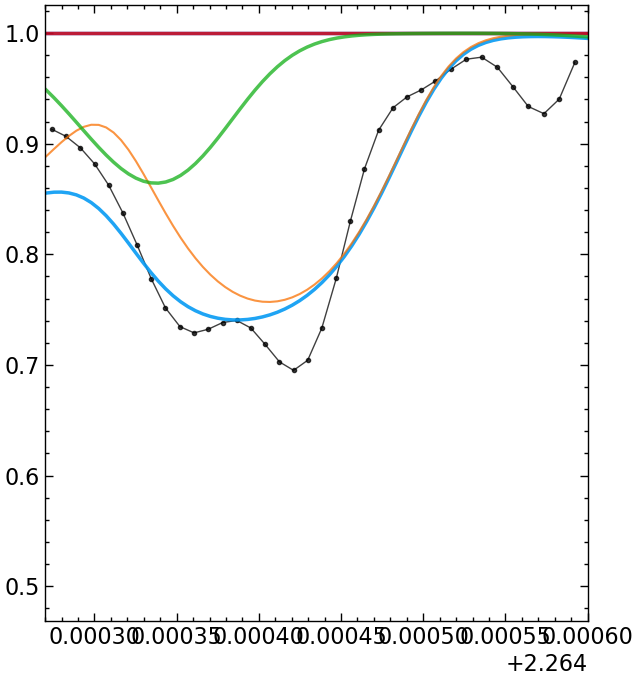

In [31]:
plt.figure(figsize=(7, 8))
l, r = 22642.7,  22646
l, r = l*1e-4, r*1e-4
mask = (wavecorr > l) & (wavecorr < r) 
plt.xlim(l,r)

plt.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
plt.plot(wavelength*1e-4, syntflux_all, lw = 2.5, c = 'xkcd:azure', alpha = 0.9, label = r"full")
plt.plot(wavelength*1e-4, syntflux_atoms, lw = 1.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
plt.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
plt.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
plt.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
l, r = l*1e4, r*1e4
c = 0.5*(l+r)
print(f"{c:.2f}  {l:.2f}  {r:.2f}")